In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import joblib
from sklearn.ensemble import RandomForestClassifier

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report
# Other
from IPython.display import Image
import configparser
import gc # clear RAM
import subprocess
import warnings
import pprint
import time
import os

In [4]:
### Let's set working directory and import our data
df = pd.read_csv('E:\\D_data\\Info\\A\\Nimmetry\\train.csv')
### and test if everything OK # Getting top 5 observations in the dataset
df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [5]:
# No .of rows and columns
df.shape

(595212, 59)

In [6]:
#Seperating features
#The dataset includes numerical, categorical and binary features. The numerical features consist of ordinal  and float values.
#Each feature type needs to be treated separately, so first of all we can create three lists of columns for the three feature 
#types.separate col names into categories
cols = df.columns
num_feats, cat_feats, bin_feats = [], [], []

for col in cols:
    if col == 'id' or col == 'target':
        pass
    elif '_cat' in col:
        cat_feats.append(col)
    elif '_bin' in col:
        bin_feats.append(col)
    else:
        num_feats.append(col)
        
print('--- Numerical features --- : ', '\n', num_feats, '\n')
print('--- Categorical features --- : ', '\n', cat_feats, '\n')
print('--- Binary features --- : ', '\n', bin_feats, '\n')

--- Numerical features --- :  
 ['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14'] 

--- Categorical features --- :  
 ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat'] 

--- Binary features --- :  
 ['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin'] 



In [7]:
print ('No. of numeric features: %d'% len(num_feats))
print ('No. of binary features: %d' % len(bin_feats))
print ('No. of Categorical features: %d' % len(cat_feats))

No. of numeric features: 26
No. of binary features: 17
No. of Categorical features: 14


In [8]:
#Data cleansing
#The next step is to check how many missing values there are for each feature type. 
#As a general rule, I like to eliminate features where more than one half of the values are missing.

# Although it uses more memory, I prefer to create a new copy of the dataframe for each section
df_cleaned = df.copy()

# I will also create copies for the feature lists
num_feats_cleaned = num_feats.copy()
cat_feats_cleaned = cat_feats.copy()
bin_feats_cleaned = bin_feats.copy()

In [9]:
#Numerical features
#Let's check for missing values (-1) in the numerical feature columns.
# I would like to eliminate any columns that consist of more than one half missing values (-1)
num_many_missing = df_cleaned[num_feats_cleaned][df == -1].count() / len(df) > 0.50 # more than 50% missing values
num_many_missing = num_many_missing.index[num_many_missing == True].tolist()
print(num_many_missing)
#No columns were returned. We can also have a look at exactly how many are missing in the applicable columns.

[]


In [10]:
counts = df_cleaned[num_feats_cleaned][df == -1].count()
cols_with_missing = counts[counts.values > 0]
print('Column  ', 'Missing count  ', 'Missing ratio')
for col, count in zip(cols_with_missing.index, cols_with_missing.values):
    print(col, '  ', count, '  ', '{:.3f}'.format(count / len(df)))

Column   Missing count   Missing ratio
ps_reg_03    107772    0.181
ps_car_11    5    0.000
ps_car_12    1    0.000
ps_car_14    42620    0.072


In [11]:
#We can substitute the missing values with the applicable column mean. This will limit their impact on the results.
# The few missing values that remain will be substituted with the column mean
for col in num_feats_cleaned:
    df_cleaned[col][df_cleaned[col] == -1] = df_cleaned[col].mean()
# Check that no missing values remain
(df_cleaned[num_feats_cleaned] == -1).sum().sum()   # sums instances of true for each column and then sums across columns

#Hence , We can be satisfied that no missing values remain.

E:\Conda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

E:\Conda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0

In [12]:
#Categorical features
#I would like to eliminate any columns that consist of more than one-half missing values (-1). 
#If features contain a relatively small proportion of missing values, these values can be converted to 
#dummy variables and may be a useful part of the analysis.
cat_many_missing = df_cleaned[cat_feats_cleaned][df == -1].count() / len(df) > 0.5
cat_many_missing = cat_many_missing.index[cat_many_missing == True].tolist()
print(cat_many_missing)

['ps_car_03_cat']


In [13]:
# We can also have a look exactly how many are missing in the applicable columns
counts = df_cleaned[cat_feats_cleaned][df == -1].count()
cols_with_missing = counts[counts.values > 0]
print('Column  ', 'Missing count  ', 'Missing ratio')
for col, count in zip(cols_with_missing.index, cols_with_missing.values):
    print(col, '  ', count, '  ', '{:.3f}'.format(count / len(df)))

Column   Missing count   Missing ratio
ps_ind_02_cat    216    0.000
ps_ind_04_cat    83    0.000
ps_ind_05_cat    5809    0.010
ps_car_01_cat    107    0.000
ps_car_03_cat    411231    0.691
ps_car_05_cat    266551    0.448
ps_car_07_cat    11489    0.019
ps_car_09_cat    569    0.001


In [14]:
#Now I will remove the one column that I identified.
df_cleaned.drop(columns=cat_many_missing, inplace=True)

In [15]:
# The cat_feats list needs to be updated
for i in cat_many_missing: cat_feats_cleaned.remove(i)
#Remaing missing values will be converted to dummy variables during the feature engineering stage.

In [16]:
#Binary features
#Let's now check for missing values among the binary features.

bin_many_missing = df_cleaned[bin_feats_cleaned][df == -1].count() / len(df) > 0.5
bin_many_missing = bin_many_missing.index[bin_many_missing == True].tolist()
print(bin_many_missing)

[]


In [17]:
#We can be sure that there are no features with more than half of there values missing. 
#Let's just make sure that no values at all are missing for the binary features.
# Lets check for missing values, in case any exist
counts = df_cleaned[bin_feats_cleaned][df == -1].count()
cols_with_missing = counts[counts.values > 0]
cols_with_missing

Series([], dtype: int64)

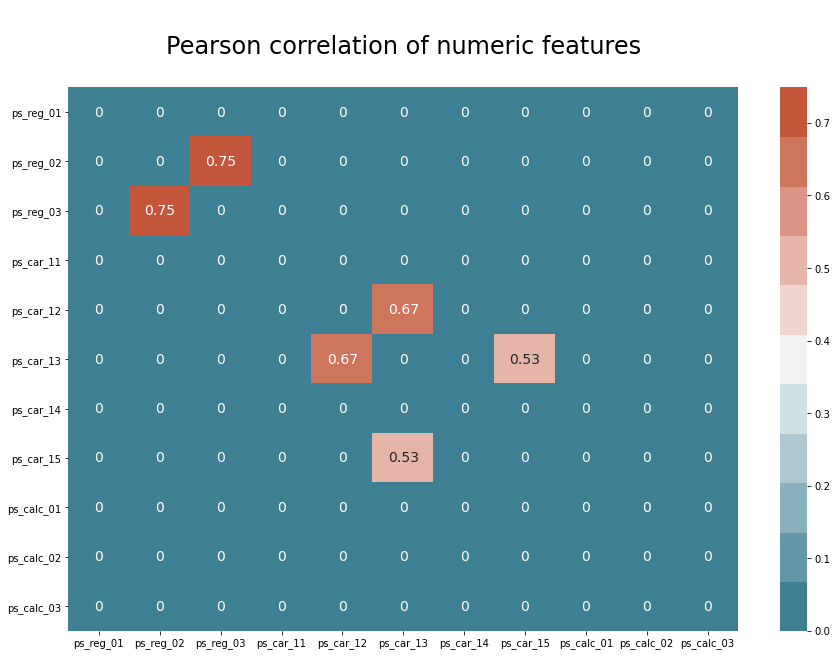

In [18]:
#Exploratory data analysis
#In this section, I will first explore the correlation between numerical features and 
#then I will explore the correlation between each feature and the target variable.

#Numerical features of float type

# First of all, we only want to select float values
df_float = df_cleaned.select_dtypes(['float64'])
df_corr = df_float.corr().abs()
# Setting a filter for values of 1 or less than 0.5
filter = (df_corr == 1) | (df_corr < 0.5)
# We can filter out values by setting them to 0
df_corr[filter] = 0
df_corr

f, ax = plt.subplots(figsize=(15, 10))
plt.title("\nPearson correlation of numeric features\n", size=24)
sns.heatmap(df_corr, annot=True, annot_kws={'size': 14},
            cmap=sns.diverging_palette(220, 20, n=11))


#We can see that there are strong correlations between four pairs of features.

#Let's look at pair plots of the strongly correlated variables. 
#This way we can gain insight into the linear correlations between the features.

In [19]:
# check correlation between cols and target
num_weak_corr = []
for col in num_feats_cleaned:
    corr, p = pointbiserialr(df_cleaned[col], df_cleaned['target'])
    if p > .05:
        print(col.upper(), ' | Correlation: ', corr, '| P-value: ', p)
        num_weak_corr.append(col)

PS_CAR_11  | Correlation:  -0.0012200059764356686 | P-value:  0.3465855778814675
PS_CALC_01  | Correlation:  0.0017819546519205688 | P-value:  0.1692009225762702
PS_CALC_02  | Correlation:  0.0013596889783313768 | P-value:  0.29417898872429776
PS_CALC_03  | Correlation:  0.0019069735964084597 | P-value:  0.14122944863624004
PS_CALC_04  | Correlation:  3.2720455100513886e-05 | P-value:  0.9798605213204049
PS_CALC_05  | Correlation:  0.0007708801365325178 | P-value:  0.5520221328272643
PS_CALC_06  | Correlation:  8.182225978058816e-05 | P-value:  0.9496663862997508
PS_CALC_07  | Correlation:  -0.00010347690485252616 | P-value:  0.9363706750415502
PS_CALC_08  | Correlation:  -0.0010058548384190228 | P-value:  0.4377398857962218
PS_CALC_09  | Correlation:  0.0007189675843641383 | P-value:  0.579111996896382
PS_CALC_10  | Correlation:  0.001060834044478951 | P-value:  0.4131106666326748
PS_CALC_11  | Correlation:  0.000371437394891013 | P-value:  0.7744467192571259
PS_CALC_12  | Correlation

In [20]:
#Categorical features
#For checking correlation between the categorical features and the target variable, we can create a crosstab table
#using Pandas and apply the Chi-squared tool to determine a p-value. Once again, 
#if the p-value is more than 0.05, then we could reject that feature.

cat_weak_corr = []
for col in cat_feats_cleaned:
    crosstab = pd.crosstab( df['target'], df_cleaned[col],  rownames = ['target'] , colnames =['feature'])
    chi2, p, dof, ex = chi2_contingency(crosstab, correction=False)
    if p > 0.05:
        print(col.upper(), ' | Chi2: ', chi2, ' | p-value: ', p)
        cat_weak_corr.append(col)
#It appears that all but one of the categorical features are worth keeping.

PS_CAR_10_CAT  | Chi2:  0.6489747744859562  | p-value:  0.7228978253269899


In [21]:
#Binary features
#We can do the same for the binary variables as we did for the categorical variables.
bin_weak_corr = []
for col in bin_feats_cleaned:
    crosstab = pd.crosstab( df['target'], df_cleaned[col],  rownames = ['target'] , colnames =['feature'])
    chi2, p, dof, ex = chi2_contingency(crosstab)
    if p > 0.05:
        print(col.upper(), ' | Chi2: ', chi2, ' | p-value: ', p)
        bin_weak_corr.append(col)

PS_IND_10_BIN  | Chi2:  1.4908391520731943  | p-value:  0.22208630630633355
PS_IND_11_BIN  | Chi2:  2.192129807260059  | p-value:  0.13871738717830912
PS_IND_13_BIN  | Chi2:  3.188775952779365  | p-value:  0.07414551103659972
PS_CALC_15_BIN  | Chi2:  0.135285302884501  | p-value:  0.7130137900732124
PS_CALC_16_BIN  | Chi2:  0.22479812854296694  | p-value:  0.6354080551735377
PS_CALC_17_BIN  | Chi2:  0.015449567540015549  | p-value:  0.9010806852088695
PS_CALC_18_BIN  | Chi2:  0.17519257769002702  | p-value:  0.6755376371151457
PS_CALC_19_BIN  | Chi2:  1.7905405627285798  | p-value:  0.1808603146226591
PS_CALC_20_BIN  | Chi2:  0.6685114869634994  | p-value:  0.413571052217771


In [22]:
#Using classification tools
#Another approach is to use a classication tool - such as random forest - to determine the importance of each feature.
#We can achieve this by fitting a model and then calling the feature_importances method.
# Sets up a classifier and fits a model to all features of the dataset
clf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
clf.fit(df_cleaned.drop(['id', 'target'],axis=1), df_cleaned['target'])
# We need a list of features as well
features = df_cleaned.drop(['id', 'target'],axis=1).columns.values
print("--- COMPLETE ---")

--- COMPLETE ---


In [23]:
joblib.dump(clf, 'clf_model.pkl')

['clf_model.pkl']

In [24]:
##Knowing feature importance indicated by machine learning models can benefit you in multiple ways, for example:
#by getting a better understanding of the model’s logic you can not only verify it being correct but also work on
#improving the model by focusing only on the important variables the above can be used for variable selection 
#you can remove x variables that are not that significant and have similar or better performance in much shorter training time
#in some business cases it makes sense to sacrifice some accuracy for the sake of interpretability

x, y = (list(x) for x in zip(*sorted(zip(clf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = None,
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Ranking of most influential features',
     width = 900, height = 1500,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

In [25]:
#Feature selection
#I would like to select only the features that have the greatest impact according to the graph above,
#with a combination of all features types.
feats_to_keep = ['ps_ind_06_bin',
                     'ps_car_15',
                     'ps_ind_07_bin',
                     'ps_car_12',
                     'ps_car_01_cat',
                     'ps_ind_15',
                     'ps_car_14',
                     'ps_car_04_cat',
                     'ps_car_07_cat',
                     'ps_ind_03',
                     'ps_reg_02',
                     'ps_ind_17_bin',
                     'ps_reg_03',
                     'ps_ind_05_cat',
                     'ps_car_13']

In [26]:
# create new dataframe with only selected features, target and id
df_select_feats = df_cleaned[['id', 'target'] + feats_to_keep]

# separate col names into categories
num_feats_to_keep, cat_feats_to_keep, bin_feats_to_keep = [], [], []

for col in feats_to_keep:
    if col == 'id' or col == 'target':
        pass
    elif '_cat' in col:
        cat_feats_to_keep.append(col)
    elif '_bin' in col:
        bin_feats_to_keep.append(col)
    else:
        num_feats_to_keep.append(col)
        
print('--- Numerical features --- : ', '\n', num_feats_to_keep, '\n')
print('--- Categorical features --- : ', '\n', cat_feats_to_keep, '\n')
print('--- Binary features --- : ', '\n', bin_feats_to_keep, '\n')

--- Numerical features --- :  
 ['ps_car_15', 'ps_car_12', 'ps_ind_15', 'ps_car_14', 'ps_ind_03', 'ps_reg_02', 'ps_reg_03', 'ps_car_13'] 

--- Categorical features --- :  
 ['ps_car_01_cat', 'ps_car_04_cat', 'ps_car_07_cat', 'ps_ind_05_cat'] 

--- Binary features --- :  
 ['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_17_bin'] 



In [27]:
#Feature engineering
#We still need to deal with the categorical variables because they cannot read in as they are. We need to create dummy variables
#for each feature. This will greatly increase the number of features that we have,so I would like to minimize these features 
#if I can.
df_engineered = df_select_feats.copy()


In [28]:
#We can check how many categories there are for each feature. This way we know which features are going to result in 
#the most additional features after converting them to dummy variables.
df_engineered[cat_feats_to_keep].nunique()

ps_car_01_cat    13
ps_car_04_cat    10
ps_car_07_cat     3
ps_ind_05_cat     8
dtype: int64

In [29]:
# convert cat feats to dummy variables (0s and 1s)
cat_dummy_df = pd.get_dummies(df_engineered[cat_feats_to_keep].astype(str))
# replacing original cat cols with new dummie cols
df_engineered = pd.concat([df_engineered, cat_dummy_df], axis=1).drop(columns=cat_feats_to_keep)

In [30]:
df_engineered.shape

(595212, 47)

In [31]:
#Class balancing
#1. There is very high imbalance which is evident of the fact that only a small number of people actually file their claim.
#2. Accuracy is not a good metric in this case.Recall and F1-Score is a better option.
#Before going into feature scaling, I would like to check out the ratio of ones to zeros in the target variable. 
#The reason I want to do this is because I already know that there is a very large class imbalance.
#We would not expect half of the people who are insured to lodge a claim.

df_engineered['target'].value_counts()

#Sure enough, there are many more zeros. We can either over-sample (duplicate the training examples corresponding to the ones)
#or under-sample (remove training examples corresponding to the zeros).

0    573518
1     21694
Name: target, dtype: int64

In [32]:
# number of zeros
num_zeros = (df_engineered['target'] == 0).sum()
# number of ones
num_ones = (df_engineered['target'] == 1).sum()
# difference in the number of zeros and ones
diff = num_zeros - num_ones
# ratios
ones_to_zeros = num_ones / num_zeros
zeros_to_ones = num_zeros / num_ones
print('Ratio of ones to zeros: ', ones_to_zeros * 100, ' %')

Ratio of ones to zeros:  3.7826188541597645  %


In [33]:
rows = len(df)
#Sampling from examples with a target of zero
#I would like to select a sample that makes up half of the original length of the dataset.
df_zeros = df_engineered[df_engineered['target'] == 0]
df_zeros_sample = df_zeros.sample(n=int(rows / 2), random_state=42)
df_zeros_sample.reset_index(inplace=True, drop=True)

In [34]:
df_zeros_sample.head()

,id,target,ps_ind_06_bin,ps_car_15,ps_ind_07_bin,ps_car_12,ps_ind_15,ps_car_14,ps_ind_03,ps_reg_02,...,ps_car_07_cat_0,ps_car_07_cat_1,ps_ind_05_cat_-1,ps_ind_05_cat_0,ps_ind_05_cat_1,ps_ind_05_cat_2,ps_ind_05_cat_3,ps_ind_05_cat_4,ps_ind_05_cat_5,ps_ind_05_cat_6
0,465947,0,1,0.000000,0,0.624980,5,0.422493,3,0.2,...,0,1,0,1,0,0,0,0,0,0
1,381915,0,0,3.741657,0,0.316228,6,0.288791,9,0.5,...,0,1,0,1,0,0,0,0,0,0
2,1060494,0,1,3.464102,0,0.400000,8,0.407431,7,0.8,...,0,1,0,1,0,0,0,0,0,0
3,469383,0,0,3.000000,1,0.374166,13,0.382099,8,0.4,...,0,1,0,1,0,0,0,0,0,0
4,491496,0,1,3.741657,0,0.400000,12,0.309677,2,0.2,...,0,1,0,1,0,0,0,0,0,0


In [35]:
#Duplicating examples with a target of one
#I will duplicate all of the examples corresponding to ones.
df_ones = df_engineered[df_engineered['target'] == 1]
# Adds duplicates of the ones set until half of the dataset is occupied
df_ones_dup = pd.DataFrame()
for i in range(int((rows / 2) / num_ones)):
    df_ones_dup = df_ones_dup.append(df_ones)

In [36]:
#Combining examples into one dataset
df_rebalanced = pd.concat([df_zeros_sample, df_ones_dup])
df_rebalanced = df_rebalanced.sample(frac=1).reset_index(drop=True)

In [37]:
df_rebalanced.shape

(579628, 47)

In [38]:
#The number of rows is similar to what we started with.

#Feature scaling
#Scaling features tends to lead to a performance improvement with classification problems, so we will do it here.

df_scaled = df_rebalanced.copy()
df_scaled.drop(columns=['target', 'id'], inplace=True)
# Set up scaler and create a scaled input matrix
scaler = MinMaxScaler()
# MinMaxScalar outputs data as a numpy array (which is necessary for XGBoost)
X_scaled = scaler.fit_transform(df_scaled)

# 1.The Simple Logistic Regression Model seems to have high accuracy. Is that what we need at all? What is the problem with this model? 

Here , we have a scenario where the number of observations belonging to one class is significantly lower than those belonging to the other classes ( 0 and 1) Which we call it as Im_balanced target variable . 

So , it involves first using a classification model to make a prediction for each example in a test dataset. The predictions are then compared to the known labels for those examples in the test set. Accuracy is then calculated as the proportion of examples in the test set that were predicted correctly, divided by all predictions that were made on the test set.

#Accuracy = Correct Predictions / Total Predictions

So , Classification accuracy fails on classification problems with a skewed class distribution because of the intuitions developed by practitioners on datasets with an equal class distribution.

No , im my model building i have XGBOOST and MLP Classifier performed better than Logistic regression.

F1-score: This is the harmonic mean of Precision and Recall and gives a better measure of the incorrectly classified cases than the Accuracy Metric.


# 2. Why do you think f1-score is 0.0? 
No , here F1-Score is not 0. Yes , it becomes zero 

F1_Score:

As The F1 score is the harmonic mean of precision and recall taking both metrics into account in the following equation:

We use the harmonic mean instead of a simple average because it punishes extreme values. A classifier with a precision of 1.0 and a recall of 0.0 has a simple average of 0.5 but an F1 score of 0. The F1 score gives equal weight to both measures and is a specific example of the general metric which can be adjusted to give more weight to either recall or precision. (There are other metrics for combining precision and recall, such as the Geometric Mean of precision and recall, but the F1 score is the most commonly used.) If we want to create a balanced classification model with the optimal balance of recall and precision, then we try to maximize the F1 score.

# 3.What is the precision and recall score for the model? 
Precision quantifies the number of positive class predictions that actually belong to the positive class. Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.

For Logistic Regression Precison and Recall Score are in the below matrix output .

#The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

#F1 = 2 * (precision * recall) / (precision + recall)



In [ ]:
# Choosen Models:
#Logistic Regression is used when the dependent variable(target) is categorical.
#XGBoost : learning_ratefloat, default=0.1 learning rate shrinks the contribution of each tree by learning_rate. 
#There is a trade-off between learning_rate and n_estimators.

n_estimatorsint, default=100

#The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually 
#results in better performance

max_depthint, default=3

#maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. 
#Tune this parameter for best performance; the best value depends on the interaction of the input variables.

In [43]:
X = X_scaled
# y needs to be converted to an array
y = df_rebalanced['target'].to_numpy()
# split up the data and target values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

models = []
models.append(('LogReg', LogisticRegression()))
models.append(('XGBoost', XGBClassifier(learning_rate =0.1,n_estimators=100,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27)))
models.append(('LinearSVC',LinearSVC(dual = True,max_iter=1000)))
models.append(('MLPClassifier',MLPClassifier(hidden_layer_sizes=(10, ), activation='relu', solver='adam', alpha=0.0001, 
                                             batch_size='auto', 
                                             learning_rate='constant', learning_rate_init=0.001)))
models.append(('AdaBoost',AdaBoostClassifier(base_estimator=None, n_estimators=50, 
                                             learning_rate=1.0, random_state=None)))

for name, model in models:
    print('\n++++++++++++++ {} ++++++++++++++\n'.format(name))

    # Train model
    print('\n--- Training model using {} ---'.format(name))
    model.fit(X_train, y_train)
    print('=== DONE ===\n')
    
    # Save model
    joblib.dump(model, '{}_model_trained.pkl'.format(name))
    
    # Make predictions on the test-set
    y_pred = model.predict(X_test)

    # Classification report
    report = classification_report(y_test, y_pred)
    print('\n', report, '\n')


++++++++++++++ LogReg ++++++++++++++


--- Training model using LogReg ---


E:\Conda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



=== DONE ===


               precision    recall  f1-score   support

           0       0.59      0.67      0.63     59421
           1       0.59      0.50      0.54     56505

    accuracy                           0.59    115926
   macro avg       0.59      0.59      0.58    115926
weighted avg       0.59      0.59      0.59    115926
 


++++++++++++++ XGBoost ++++++++++++++


--- Training model using XGBoost ---
=== DONE ===


               precision    recall  f1-score   support

           0       0.61      0.68      0.65     59421
           1       0.62      0.54      0.58     56505

    accuracy                           0.62    115926
   macro avg       0.62      0.61      0.61    115926
weighted avg       0.62      0.62      0.61    115926
 


++++++++++++++ LinearSVC ++++++++++++++


--- Training model using LinearSVC ---
=== DONE ===


               precision    recall  f1-score   support

           0       0.59      0.68      0.63     59421
           1       0.59  

# 4. What is the most important inference you can draw from the result? 
#Modelling
After a thorough EDA and preprocessing, data is ready to be fed into a machine learning model. A model also has to be hyper tuned properly for it to produce the best results. Sometimes complicated models are required for a problem but sometimes a simple model does the job for you. Therefore, it has to be seen through experimentation which model work the best. 
All the hyper-parameter tuning for the below models was done manually because of the computational overheads . Also manual tuning gave more insight on how the model behaved with small changes in the parameters. The code snippets above are only the final stages of the tuning process.

#Feature Selection
This step allows us to remove features from the dataset which does not provide any value in prediction for a particular model. This in-turn improves the computational speed and can also increase our model performance for different models.Only the features selected from the feature selection process were used for each of the base models. This helped in improving the final score of the model.

#Results
Out of all the models XGBoost was the best performing one followed by MLP and Adaboost. Thus those two were taken for the final stack. It is a good practice to try simple models first but in this case they didn’t work well

# 5. What is the accuracy score and f1-score for the improved Logistic Regression model? 
The accuracy score and F-score for logistic model is 63 and 59 which in matrix as above.

# 6. Why do you think f1-score has improved?
Without having access to the dataset, I'm unable to give exact pointers; so I'm suggesting a few directions to approach this problem and help improve the F1 score:

Use better features, sometimes a domain expert (specific to the problem you're trying to solve) can give relevant pointers that can result in significant improvements. As , I tried to do some feature engineering .

Use a better classification algorithm and better hyper-parameters.

#Further to do :SMOTE 
Over-sample the minority class, and/or under-sample the majority class to reduce the class imbalance.Use higher weights for the minority class, although I've found over-under sampling to be more effective than using weights.

# 7. For model LinearSVC play with parameters – _dual, max_iter and see if there is any improvement 

Yes , there is a little bit of change in F1_Score when the max_iter parameter changed from 100 to 100 . And most of the cases LinearSVC needs high number of iterations. 

# 9. XGBoost is one the better classifiers -- but still f1-score is very low. What could be the reason? 

It's not exactly low compared to MLP classifier or AdaBoost . The low F1_score may occur when the parameters are not taken properly . I considered the parameters to build the best classifier for XGBoost are:

learning_rate =0.1,n_estimators=100,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27))) . So, it's in tunin the model which gives the goof F1_Score

# 11. Is there any improvement in scores after encoding? 
Mostly , No here we can't see improvement in scores after encoding .Because of the noise generated by the variables . Which will have very less existence in the performance of model building.

# 12. If not missing a positive sample is the priority which model is best so far? 
If targeting a metric score then it's good to be with Boosting algorithms or ensembles. But , when business is concerned XGBoost is less reliable and preference after the target distribution will be taken to SVC or Logisti regression mostly.


# 13. If not marking negative sample as positive is top priority, which model is best so far? 
It's preference is based on the Varaible Importance and the conversions and collinearity in the data . As in the dataset we have faced lot many zeros in the set. So which has no high impact in model building.


# 14. Do you think using AdaBoost can give any significant improvement over XGBoost? 
No , XG boost works better than adabooost
Adaboost and XGBoost are two different ways to derive boosters. Both are generic. I like gradboosting better because it works for generic loss functions, while adaboost is derived mainly for classification with exponential loss. Both of these methods are built based on the idea of converting weak learners to a strong learner by updating based on the residuals (XGBoost) or misclassifications


# 15. MLPClassifier is the neural network we are trying. But how to choose the right no. of layers and size? 
The number of hidden neurons should be between the size of the input layer and the size of the output layer. The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.I considered 10 and 12 as size .But there is no huge difference between the metrics

# 16. At what layer size we get the best F1_score

Here , it's the 10th layer i got the best f1_Score
